In [1]:
import os
if(os.getcwd().split('/')[-1] == "ipynb"):
    os.chdir("../")
import matplotlib.pyplot as plt
import pickle
import math
import random
import numpy as np
from od.env.config import ROOT_DIR
from od.env.station import BS_PRESET
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from od.misc.statistic import NetFlowType
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":26,
    "figure.autolayout":True,
    "figure.dpi": 100,
    "axes.titlesize":"medium",
    "legend.fontsize":"x-small",
    'figure.figsize': [6,4],

    }
)
_pinf = float("inf")
_ninf = float("-inf")


In [2]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

In [3]:
# plt.rcParams.keys()

In [4]:
LINE_MARKER_STYLES = [
    marker_style + line_style
    for marker_style in ['o', 'v', '^', '<', '>', '*', 'x','d']
    for line_style in ['--', '-.', ':']
]
random.seed(1)
random.shuffle(LINE_MARKER_STYLES)


def GetLineMarkerStyle(line_no):
    return LINE_MARKER_STYLES[line_no % len(LINE_MARKER_STYLES)]


In [5]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [6]:
def ExtractAbbreviations(abbrev):
    if(abbrev.lower() == "avg"):
        return "Average"
    elif(abbrev.lower() == "max"):
        return "Maximum"
    elif(abbrev.lower() == "min"):
        return "Minimum"

In [7]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [8]:
def AdjustResAllocTypeName(alloc_type):
    if(alloc_type == ResourceAllocatorType.OMA):
        return "OMA"
    elif(alloc_type == ResourceAllocatorType.NOMA_OPT):
        return "NOMA"

In [9]:
def ScenarioPrefix(req_rsu, qos_re_class):
    if not req_rsu:
        return "MC"
    elif not qos_re_class:
        return "SA"
    return "SA+QR"

In [10]:
YRSU_SCENARIO_BS_ID = []
NRSU_SCENARIO_BS_ID = []
for name, bs_config in BS_PRESET.items():
    if (bs_config["type"] == BaseStationType.UMA):
        YRSU_SCENARIO_BS_ID.append(name)
        NRSU_SCENARIO_BS_ID.append(name)
    if (bs_config["type"] == BaseStationType.UMI):
        YRSU_SCENARIO_BS_ID.append(name)


def GetScenarioBaseStationNames(req_rsu):
    return YRSU_SCENARIO_BS_ID if req_rsu else NRSU_SCENARIO_BS_ID


In [11]:
def ScenarioNetFlowType(qos_re_class):
    if(qos_re_class):
        return NetFlowType
    else:
        return [NetFlowType.CRITICAL,NetFlowType.GENERAL]

In [28]:
qos_re_class_range = [False]
seed_range = [ (i + 1) for i in range(10) if ((i + 1) not in [9,3]) ]
res_alloc_type_range = [ResourceAllocatorType.NOMA_OPT]
req_rsu_range = [False, True]
traffic_scale_range = [ i/10 for i in range(7,15,1) ]
req_sa_qr = False

In [29]:
interest_config = InterestConfig(False, ResourceAllocatorType.NOMA_OPT, False, 0, 0)
stats = {
    qos_re_class:
    {
        seed: {
            res_alloc_type: {
                req_rsu: {
                    traffic_scale: None
                    for traffic_scale in traffic_scale_range
                }
                for req_rsu in req_rsu_range
            }
            for res_alloc_type in res_alloc_type_range
        }
        for seed in seed_range
    }
    for qos_re_class in qos_re_class_range
}
for qos_re_class in qos_re_class_range:
    for seed in seed_range:
        for res_alloc_type in res_alloc_type_range:
            for req_rsu in req_rsu_range:
                for traffic_scale in traffic_scale_range:
                    interest_config.qos_re_class = qos_re_class
                    interest_config.res_alloc_type = res_alloc_type
                    interest_config.req_rsu = req_rsu
                    interest_config.traffic_scale=traffic_scale
                    interest_config.rng_seed = seed
                    try:

                        with open(ROOT_DIR + interest_config.folder() + "report.pickle", "rb") as file:
                            # with open("data/yQoS/{}/{}/report_adjust_wait_time_nQoS.pickle".format(seed,str(interest_config)), "rb") as file:
                            stats[qos_re_class][seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                    except:
                        print("missing: {}".format(str(interest_config)))


In [30]:
np.argsort([stats[req_sa_qr][seed][ResourceAllocatorType.NOMA_OPT][True][1.4]['end-to-end']['GENERAL']['avg'] for seed in seed_range]) + 1

array([7, 6, 5, 3, 4, 2, 1, 8])

In [15]:
from matplotlib.ticker import MaxNLocator
graphs = {}
class Line:
    def __init__(self,label,x,y):
        self.label = label
        self.x = x
        self.y = y
class Graph:
    def __init__(self,title,xlabel,ylabel):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.lines = []
    def addLine(self,line:Line):
        self.lines.append(line)
def ShowGraphs(graphs,save):
    for _g,(title,graph) in enumerate(graphs.items()):
        plt.figure(_g, figsize=(9, 5))
        plt.title(title)
        plt.xlabel(graph.xlabel)
        plt.ylabel(graph.ylabel)
        plt.gca().xaxis.set_major_locator(MaxNLocator(5,min_n_ticks=3))
        for _l, line in enumerate(graph.lines):
            plt.plot(
                line.x,
                line.y,
                GetLineMarkerStyle(_l),
                label=line.label
            )
        plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
        if save :
            plt.savefig('{}/{}.pdf'.format(dirpath, title))
    plt.show()

In [16]:
configs = [
    {
        "catalog": "end-to-end",
        "topic": "End-to-End Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "wait-time",
        "topic": "Wait Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "tx-time",
        "topic": "Transfer Time",
        "x": "Average Number of Vehicles",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
]


# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in res_alloc_type_range:
                title =  "{} {}({},{})".format(
                    ExtractAbbreviations(subject), 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                for nft in ScenarioNetFlowType(req_sa_qr):
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr), nft.name.lower()),x,y)
                    )

In [17]:
configs = [
    {
        "catalog": "bst-thrput",
        "topic": "Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]
# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts)) + ["total"]
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v =  stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v/(10**6))
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [18]:
configs = [
    {
        "catalog": "bst-sg-rate",
        "topic": "QoS Service Traffic Ratio",
        "x": "Average Number of Vehicles",
        "y": "Percentage",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]


# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts))
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v =  stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*100)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [19]:
configs = [
    {
        "catalog": "sys-thrput",
        "topic": "System Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
    },
]


# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = topic
    if(title not in graphs):
        graphs[title] = Graph(title,config["x"],config["y"])
    graph = graphs[title]
    for req_rsu in req_rsu_range:
        for res_alloc_type in res_alloc_type_range:
            y = []
            x = [x * 100 for x in traffic_scale_range]
            for traffic_scale in traffic_scale_range:
                value = []
                for seed in seed_range:
                    v =  stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog]["total"]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value.append(v/10**6)
                y.append(sum(value)/len(value))
            graph.addLine(
                        Line( 
                            "{}:{}/{}".format(
                                ScenarioPrefix(req_rsu,req_sa_qr),
                                AdjustResAllocTypeName(res_alloc_type),
                                BaseStationScenario(req_rsu)
                            ),
                             x,
                             y
                        )
            )

In [20]:
configs = [
    {
        "catalog": "veh-arv-rate",
        "topic": "Vehicle Arrival&Deparature Rate",
        "x": "Average Number of Vehicles",
        "y": "Number",
        "subject": [
            ("avg", lambda x: 3**x),
            ("max", lambda x: x),
            ("min", lambda x: x)
        ],
        "io": "arv"
    },
    {
        "catalog": "veh-dep-rate",
        "topic": "Vehicle Arrival&Deparature Rate",
        "x": "Average Number of Vehicles",
        "y": "Number",
        "subject": [
            ("avg", lambda x: 3**x),
            ("max", lambda x: x),
            ("min", lambda x: x)
        ],
        "io": "dep"
    },
]

# intialize
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject, f in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    ExtractAbbreviations(subject),
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title, config["x"], config["y"])
                graph = graphs[title]
                for nft in ScenarioNetFlowType(req_sa_qr):
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v)
                        value.sort()
                        y.append(sum(value)/len(value))
                    if(max(y) > 0):
                        graph.addLine(
                            Line(
                                "{}:{}-{}".format(
                                    ScenarioPrefix(req_rsu, req_sa_qr),
                                    config["io"],
                                    nft.name.lower()
                                ),
                                x,
                                [f(v) for v in y]
                            )
                        )


In [31]:

configs = [
    {
        "catalog": "veh-arv-size",
        "topic": "Vehicle Arrival Size",
        "x": "Average Number of Vehicles",
        "y": "Bits",
        "subject": [("avg", lambda x:x),("max", lambda x: x),("min", lambda x: x)],
    },
]

# intialize
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject, f in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    ExtractAbbreviations(subject),
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title, config["x"], config["y"])
                graph = graphs[title]
                for nft in ScenarioNetFlowType(req_sa_qr):
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v)
                        value.sort()
                        if(nft == NetFlowType.GENERAL):
                            print("{}-{}:{}".format(subject,traffic_scale,value))
                        y.append(sum(value)/len(value))
                    if(max(y) > 0):
                        graph.addLine(
                            Line(
                                "{}:{}".format(
                                    ScenarioPrefix(req_rsu, req_sa_qr),
                                    nft.name.lower()
                                ),
                                x,
                                [f(v) for v in y]
                            )
                        )


avg-0.7:[8367.683911594024, 8431.014700432366, 8443.758833703978, 8445.485375786746, 8460.483082242528, 8470.738039312646, 8502.724823921908, 8508.348728081008]
avg-0.8:[8420.306086956522, 8428.05177852714, 8431.899174272055, 8449.852714021537, 8486.049141117634, 8501.059322956351, 8504.953665433979, 8513.385635118982]
avg-0.9:[8365.428127428127, 8390.182666148465, 8411.36216111165, 8433.69054552514, 8441.847228962439, 8456.002332588201, 8468.441507967353, 8504.609886374672]
avg-1.0:[8342.204282204282, 8371.921678812889, 8389.034331372377, 8435.377152899824, 8462.495042555058, 8465.30852930853, 8467.54931061737, 8497.735895411073]
avg-1.1:[8363.144887241273, 8370.295410721172, 8409.32941722059, 8439.266661518264, 8441.266769706337, 8483.938509076863, 8485.969881844157, 8498.575003862197]
avg-1.2:[8384.964425789582, 8389.83995045758, 8415.870195943624, 8421.976195390436, 8432.254763051104, 8462.304198210599, 8472.120536635706, 8507.375808449153]
avg-1.3:[8404.741568652935, 8410.31807260

In [22]:

configs = [
    {
        "catalog": "bs-arv-rate",
        "topic": "BaseStation Arrival Rate",
        "x": "Average Number of Vehicles",
        "y": "Number",
        "subject": [("avg", lambda x:x), ("max", lambda x: x), ("min", lambda x: x)],
        "io":"arv",
    },
     {
        "catalog": "bs-dep-rate",
        "topic": "BaseStation Arrival Rate",
        "x": "Average Number of Vehicles",
        "y": "Number",
        "subject": [("avg", lambda x:x), ("max", lambda x: x), ("min", lambda x: x)],
        "io":"dep",
    },
]

# intialize
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject, f in subjects:
        for req_rsu in req_rsu_range:
            scenario_bs_names = GetScenarioBaseStationNames(req_rsu)
            for res_alloc_type in res_alloc_type_range:
                for bs_id in scenario_bs_names:
                    title = "{} {}({},{},{})".format(
                        ExtractAbbreviations(subject),
                        topic,
                        BaseStationScenario(req_rsu),
                        AdjustResAllocTypeName(res_alloc_type),
                        bs_id
                    )
                    if(title not in graphs):
                        graphs[title] = Graph(title, config["x"], config["y"])
                    graph = graphs[title]
                    for nft in ScenarioNetFlowType(req_sa_qr):
                        y = []
                        x = [x * 100 for x in traffic_scale_range]
                        for traffic_scale in traffic_scale_range:
                            value = []
                            for seed in seed_range:
                                for name in scenario_bs_names:
                                    v = stats[req_sa_qr][seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][bs_id][subject]
                                    if v == _pinf or v == _ninf:
                                        v = 0
                                    value.append(v)
                            y.append(sum(value)/len(value))
                        if(max(y) > 0):
                            graph.addLine(
                                Line(
                                    "{}:{}-{}".format(
                                        ScenarioPrefix(req_rsu, req_sa_qr),
                                        config["io"],
                                        nft.name.lower(),
                                    ),
                                    x,
                                    [f(v) for v in y]
                                )
                            )


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
/tmp/ipykernel_2605187/1197658460.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(_g, figsize=(9, 5))
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


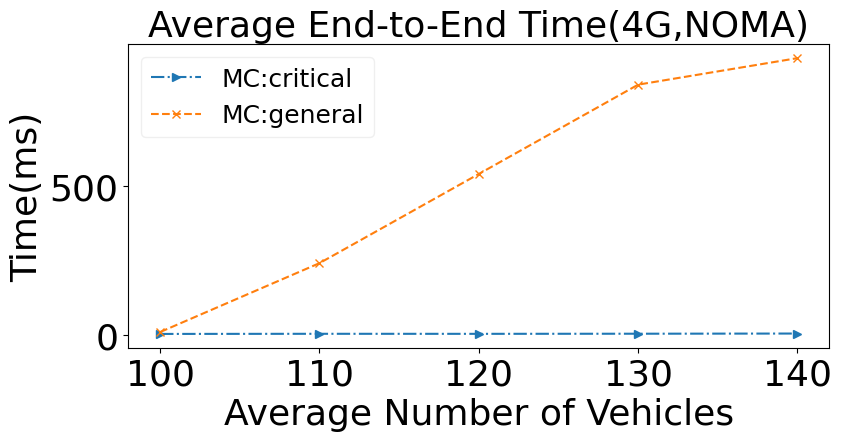

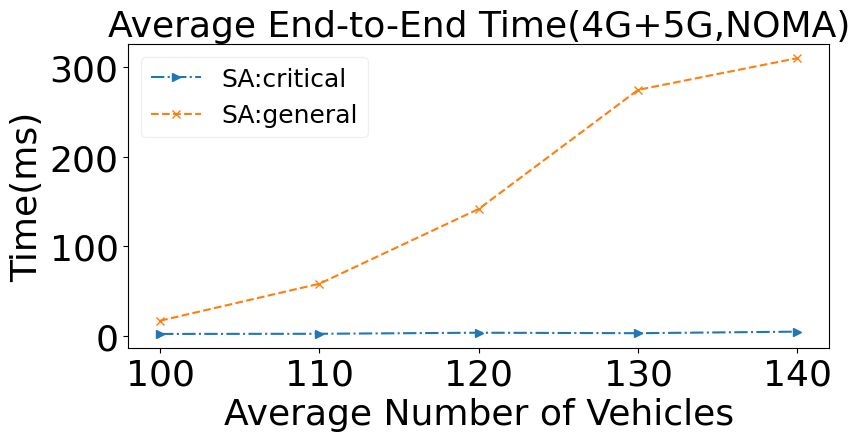

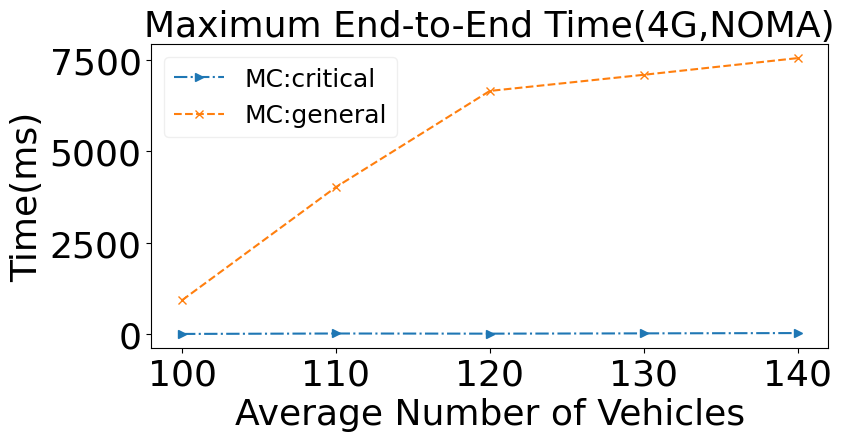

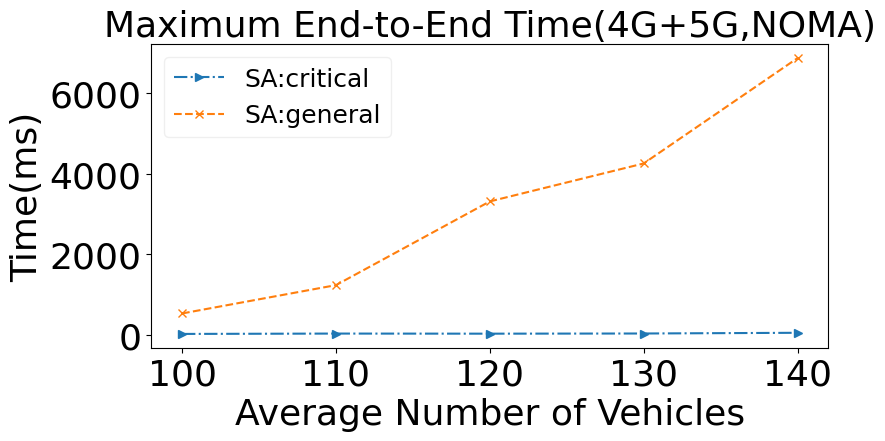

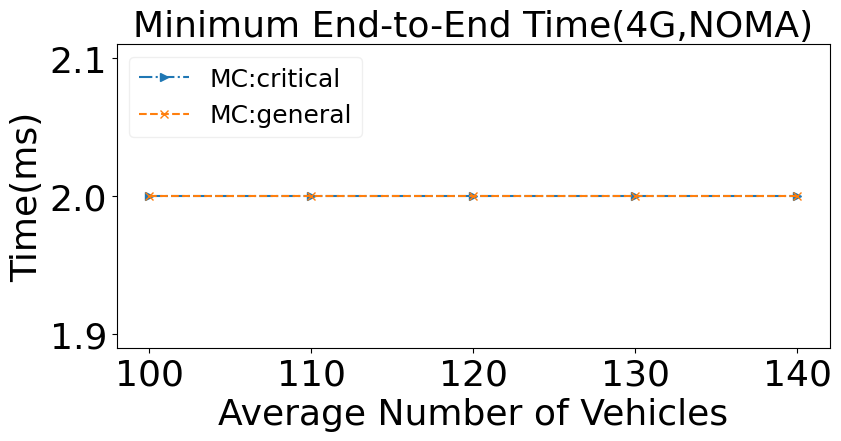

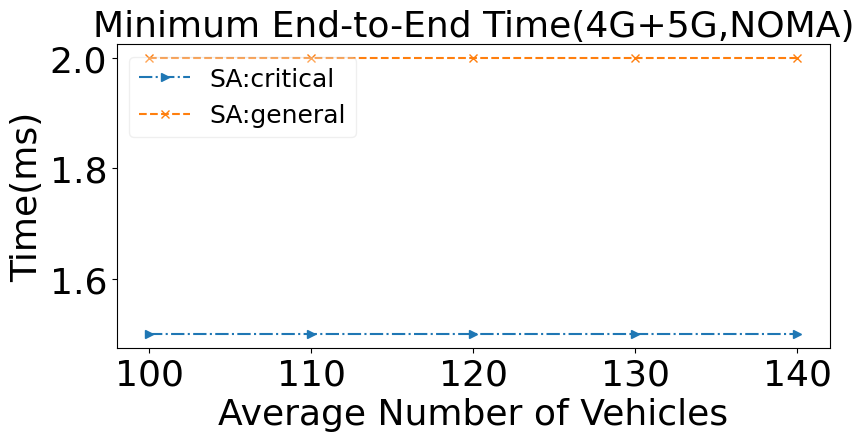

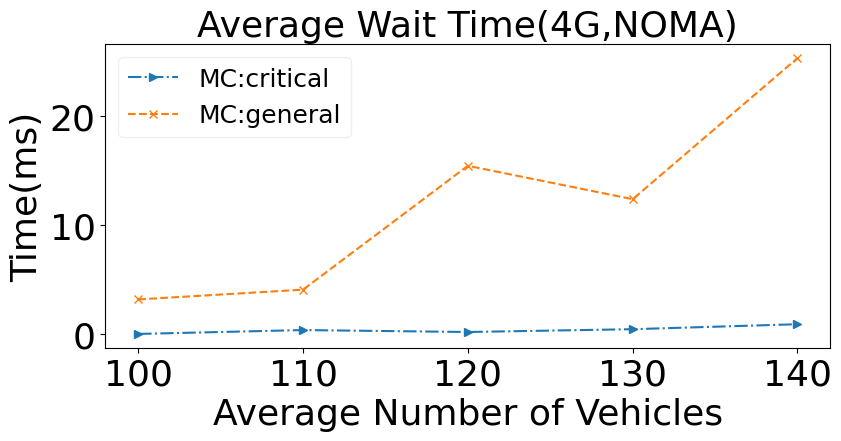

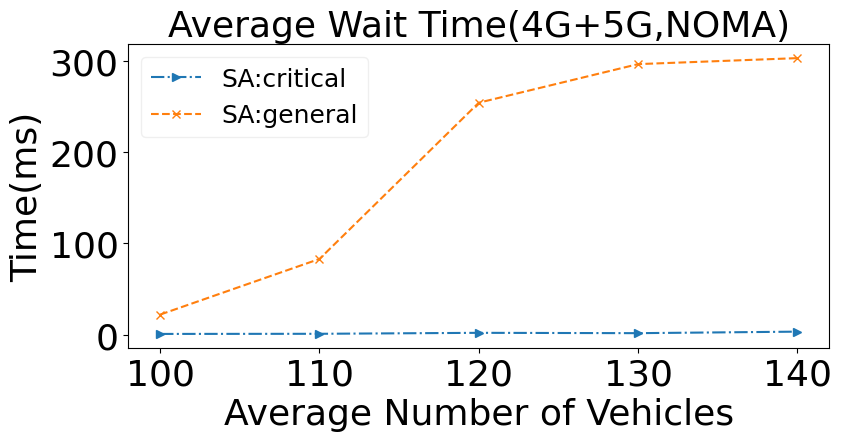

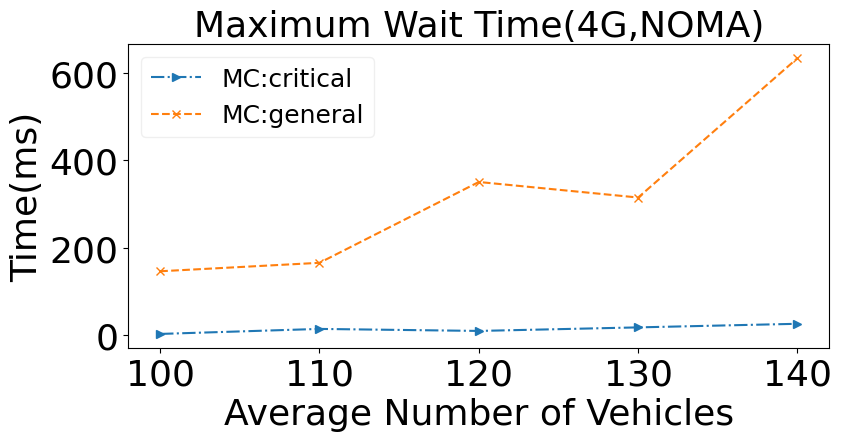

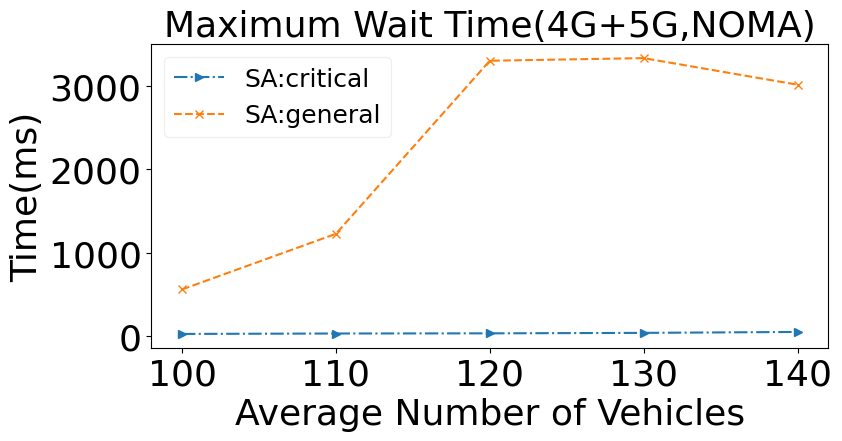

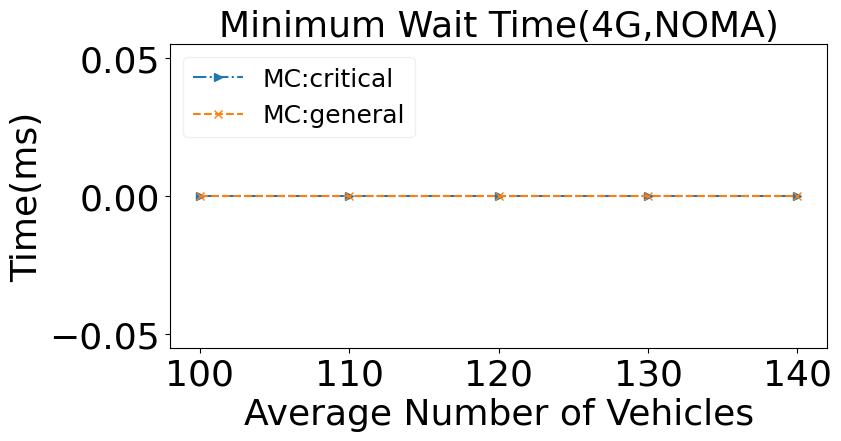

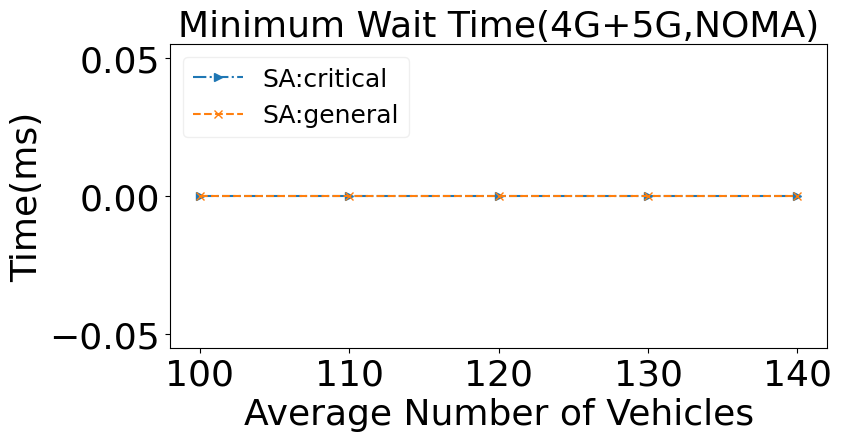

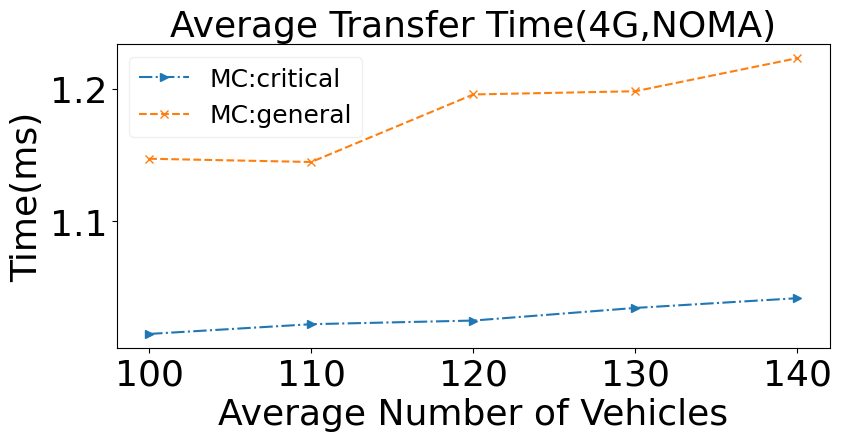

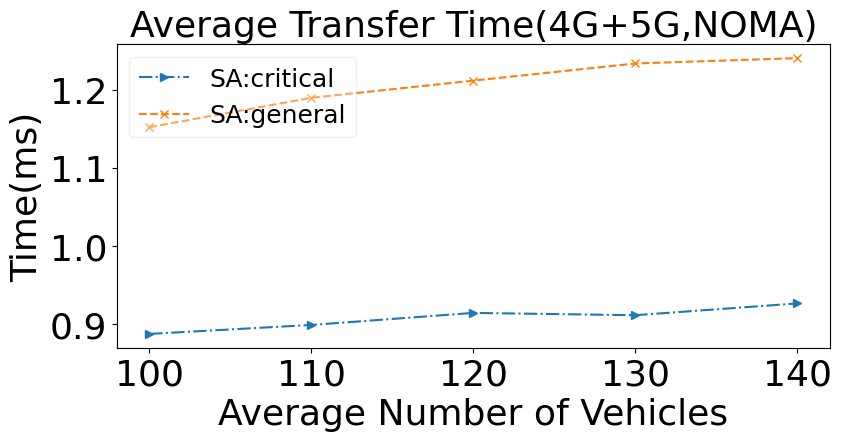

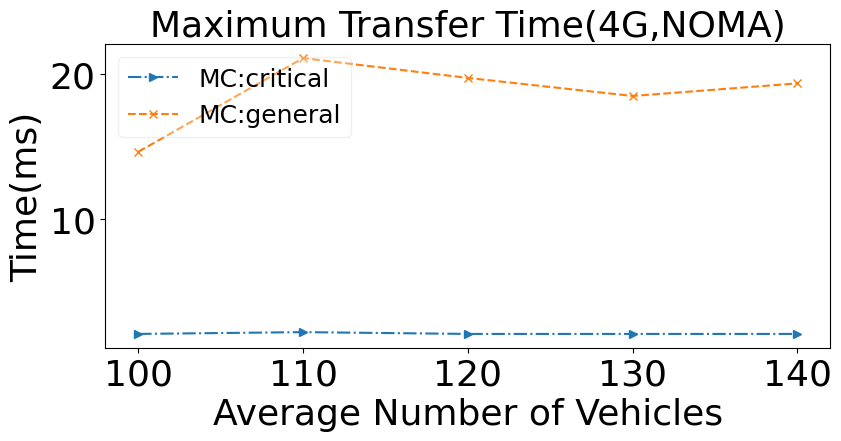

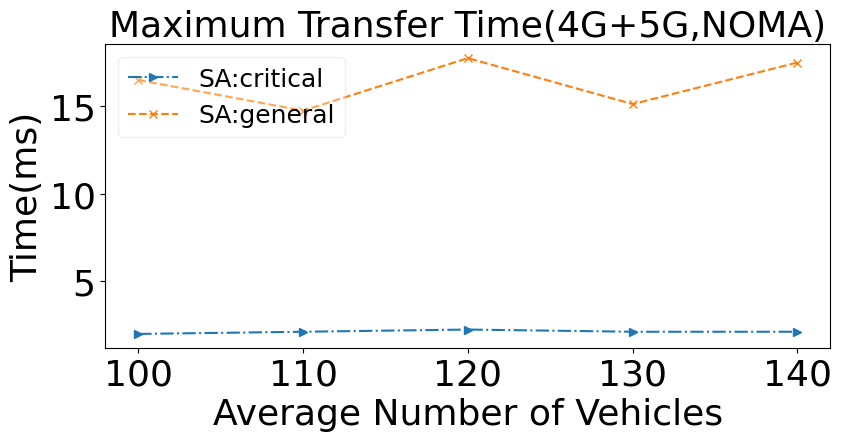

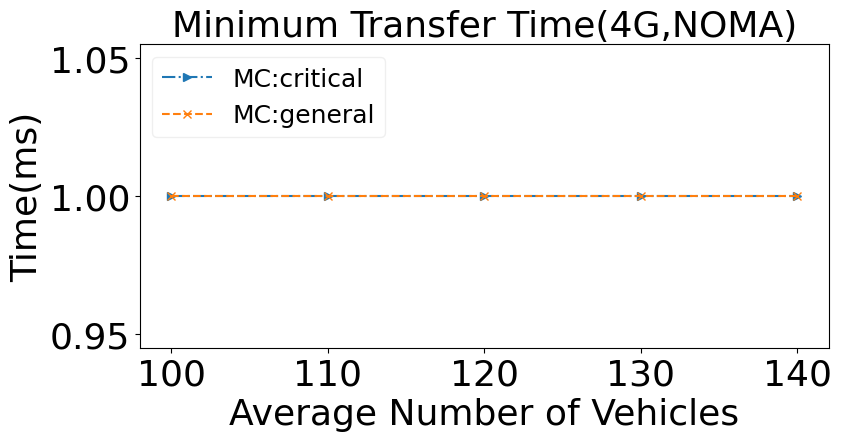

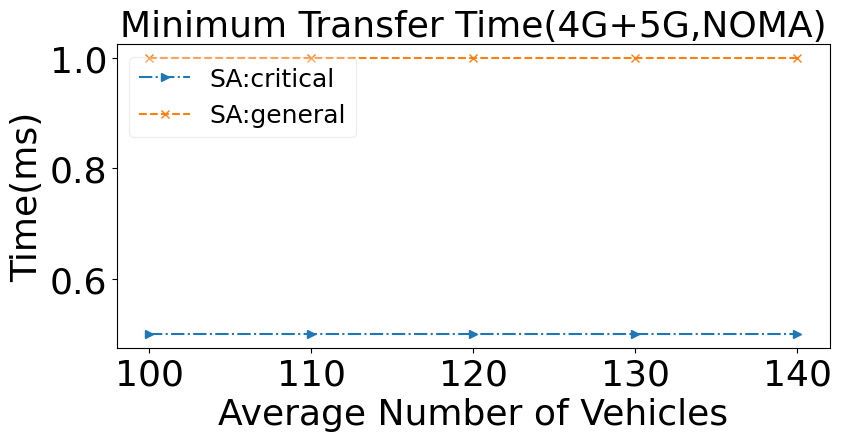

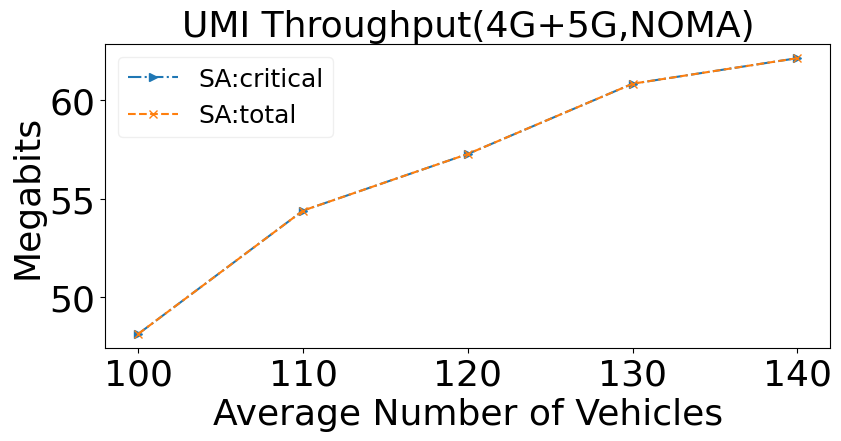

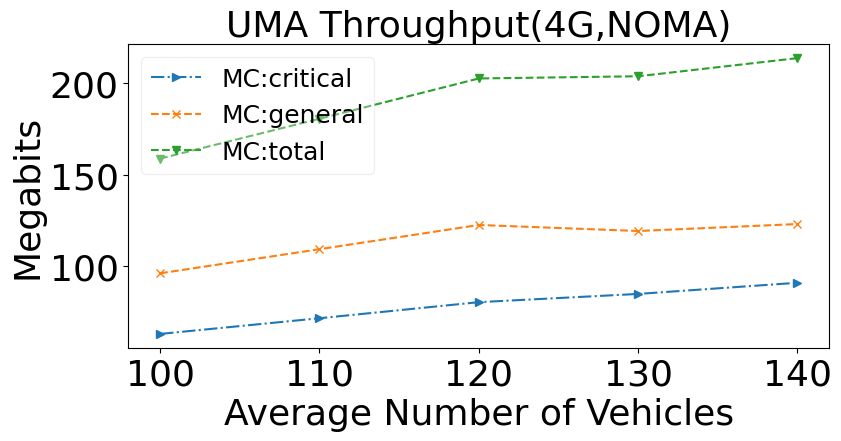

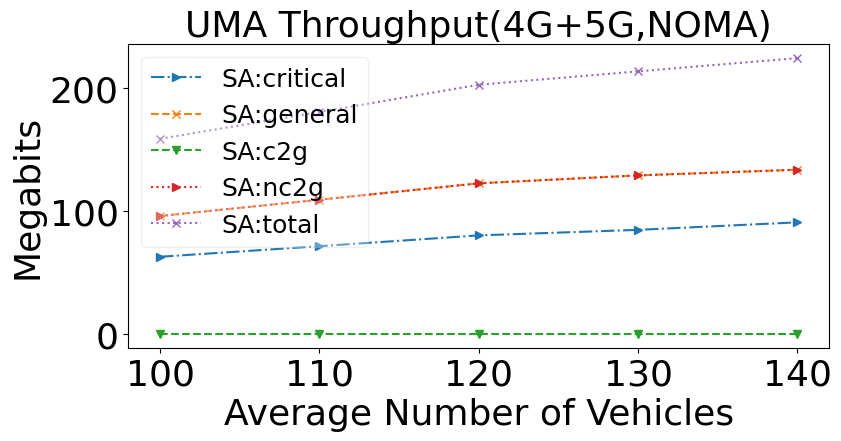

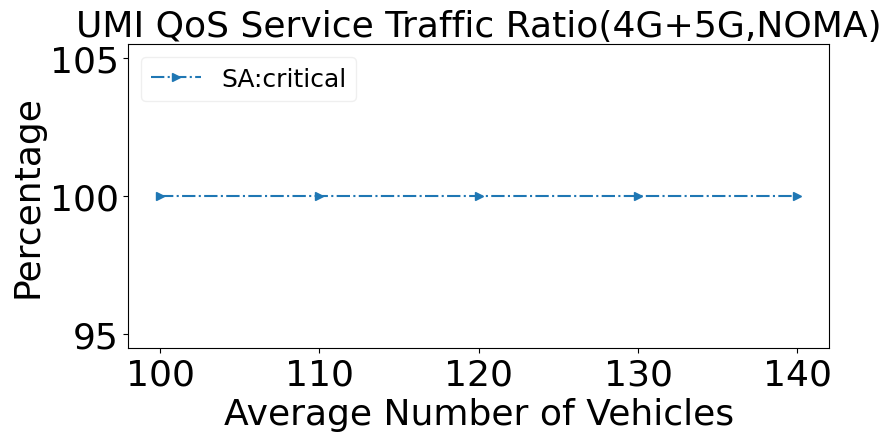

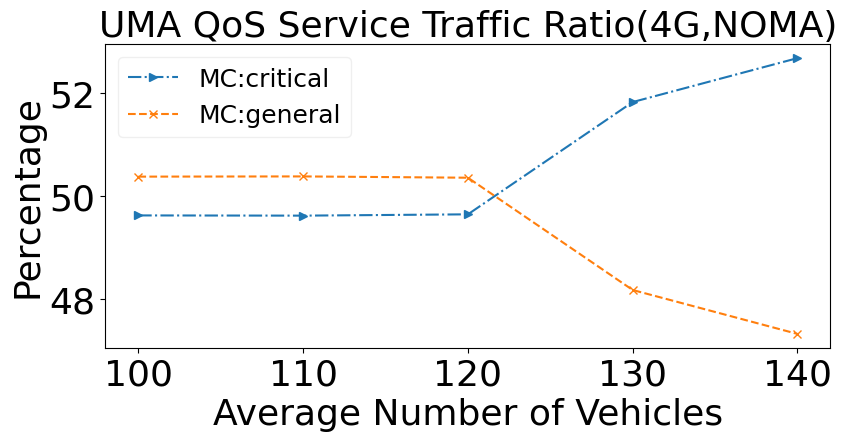

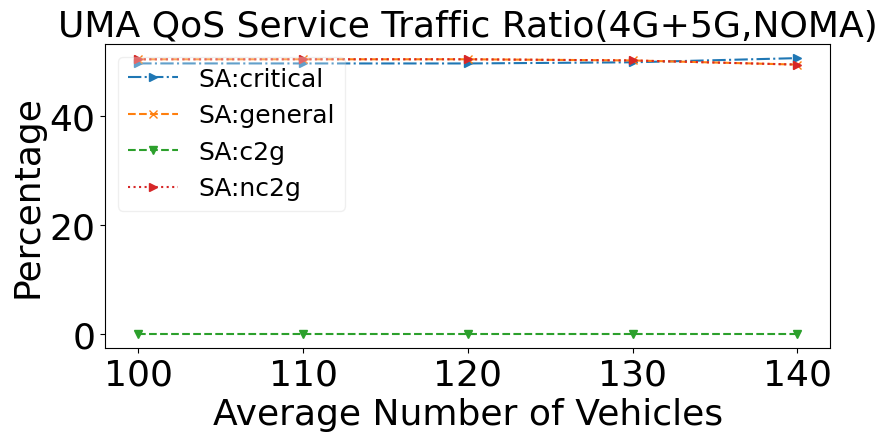

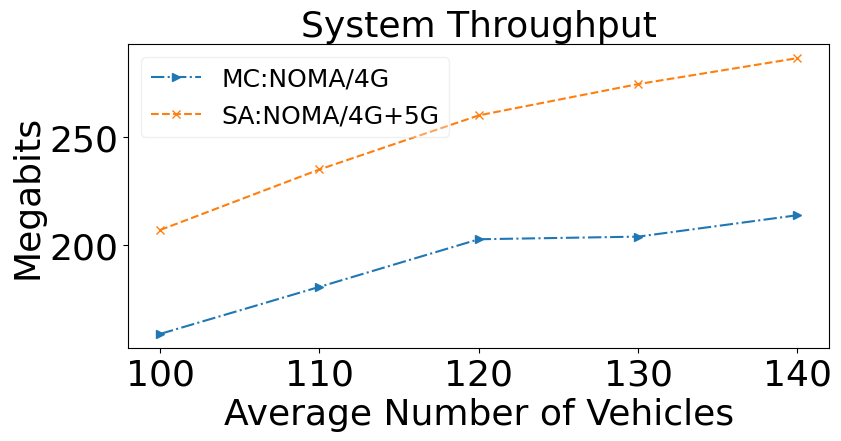

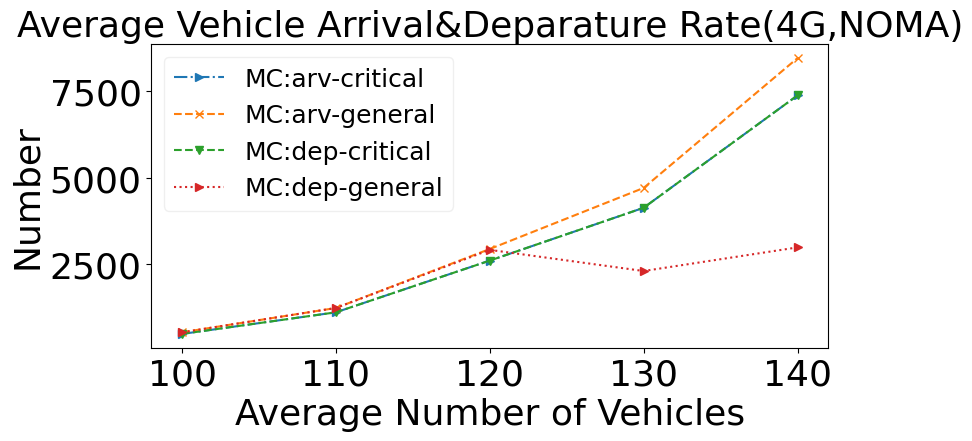

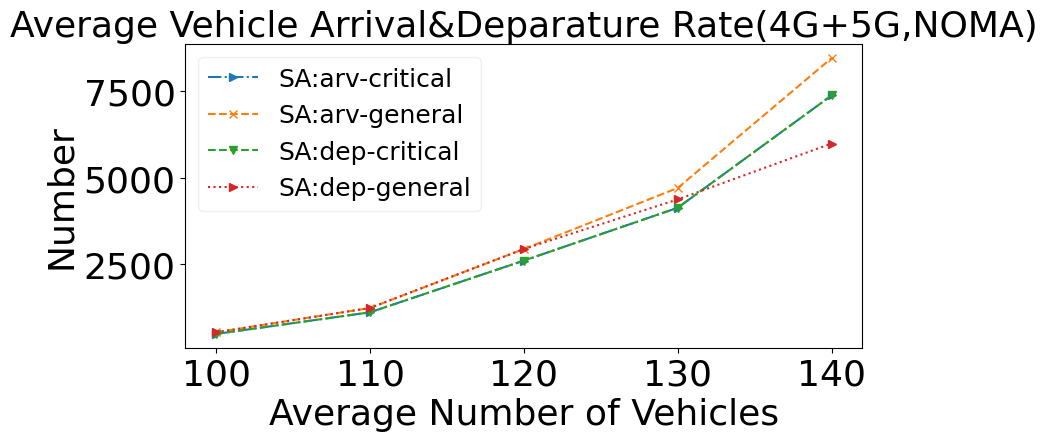

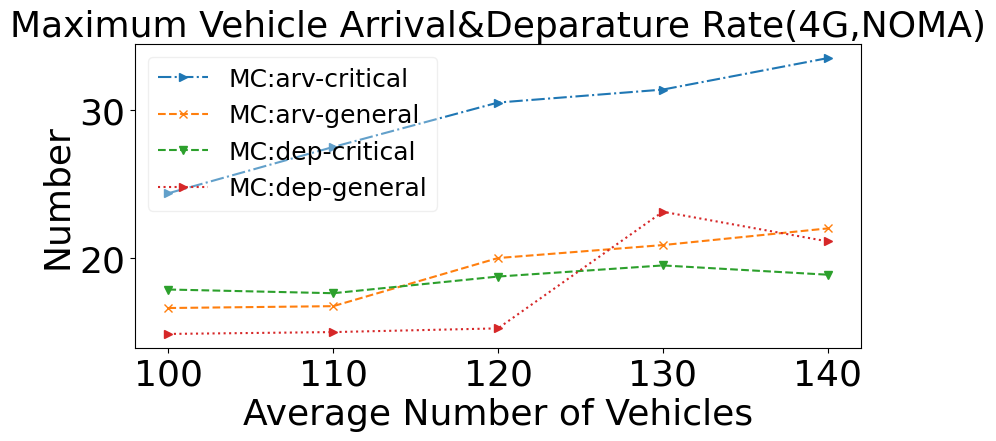

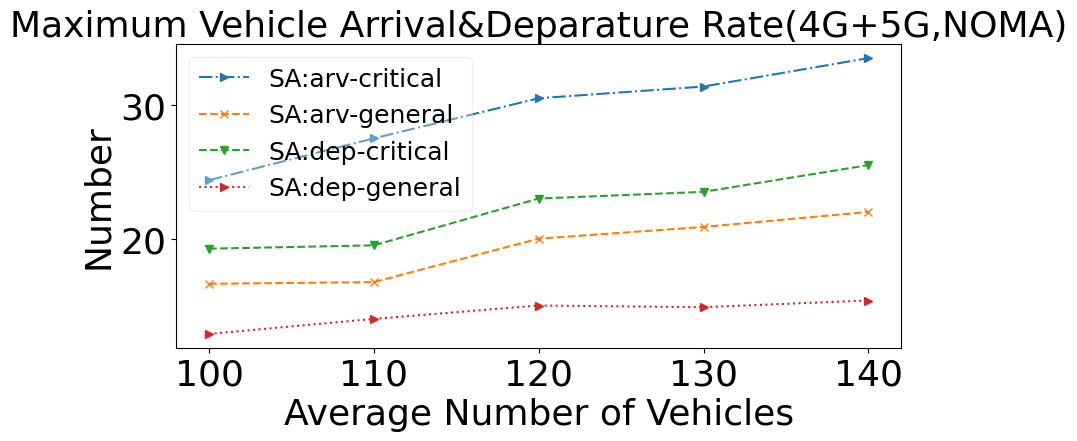

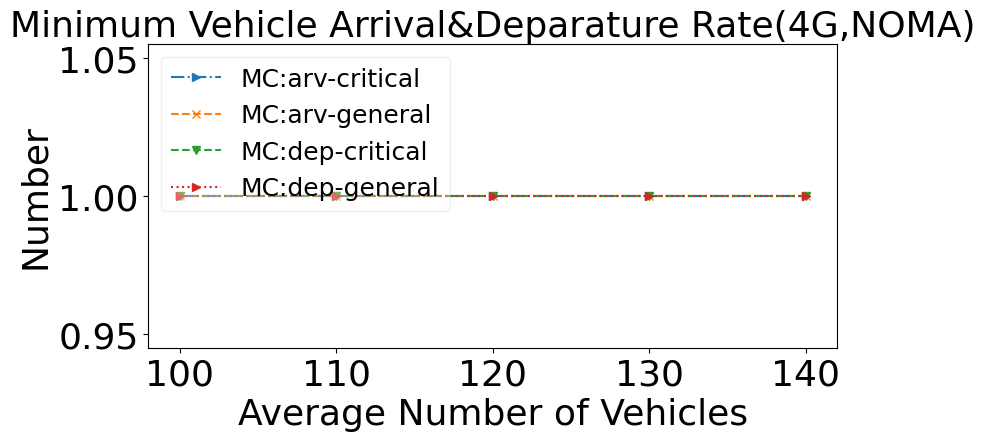

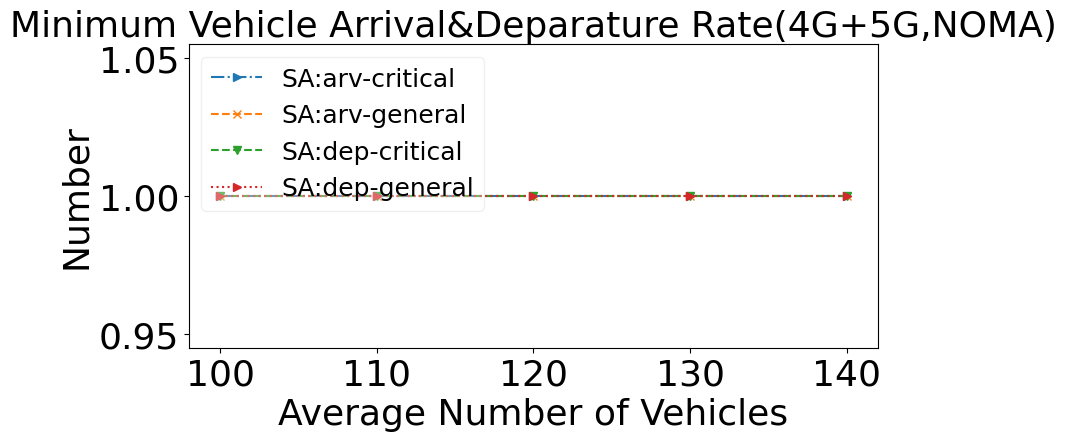

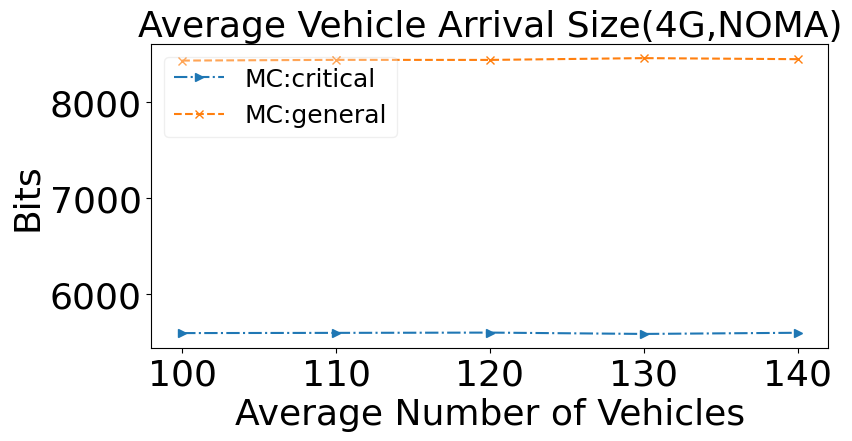

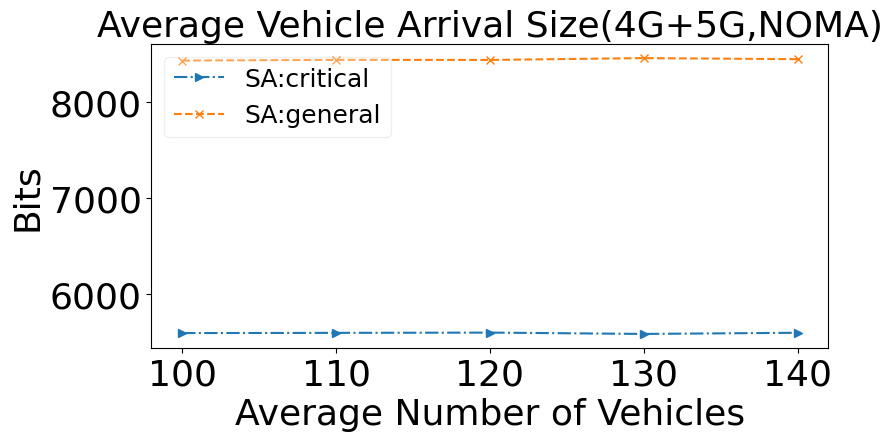

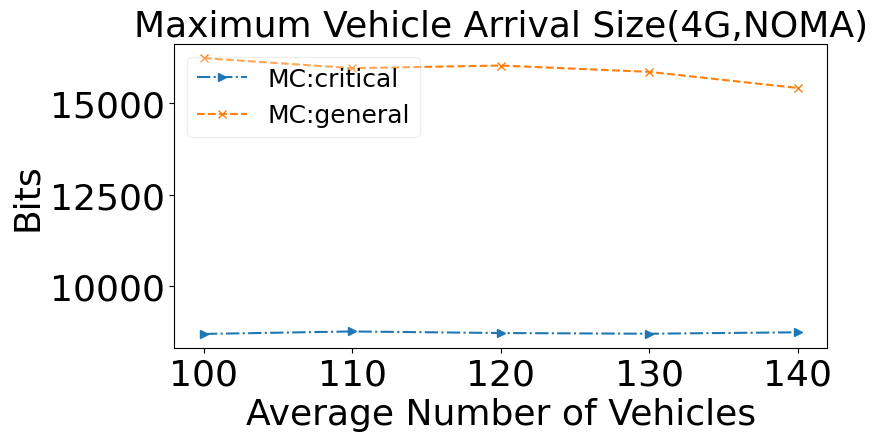

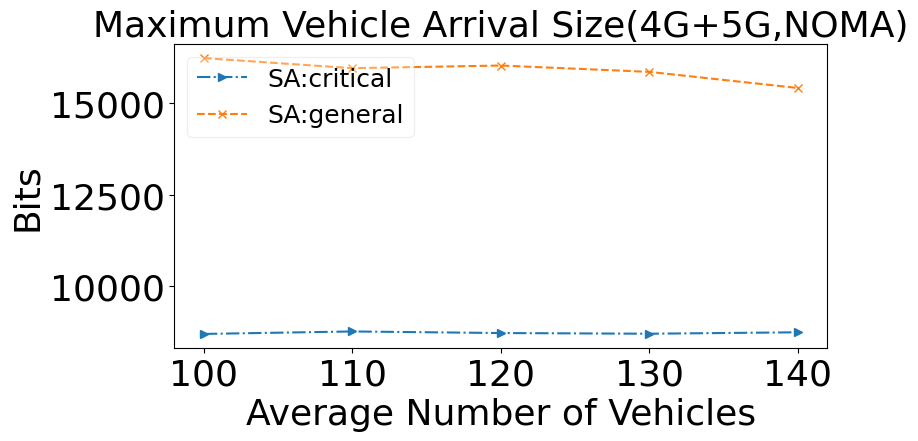

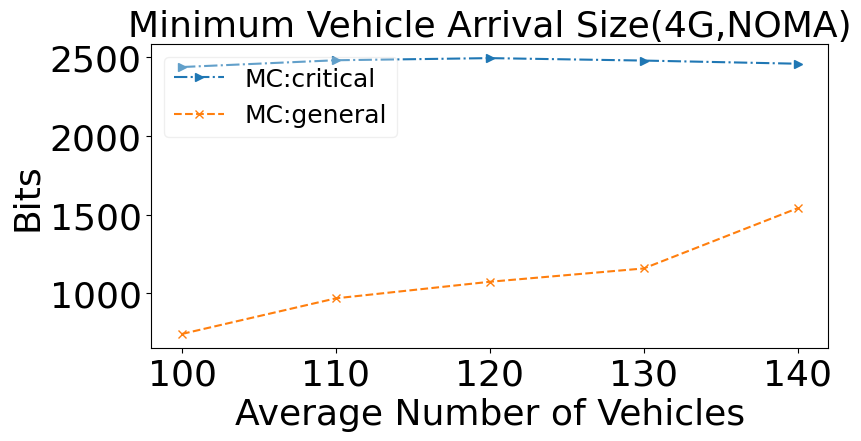

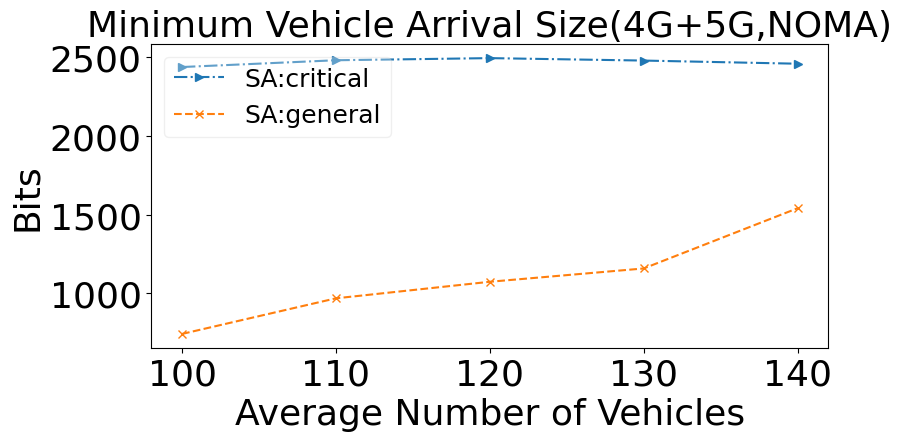

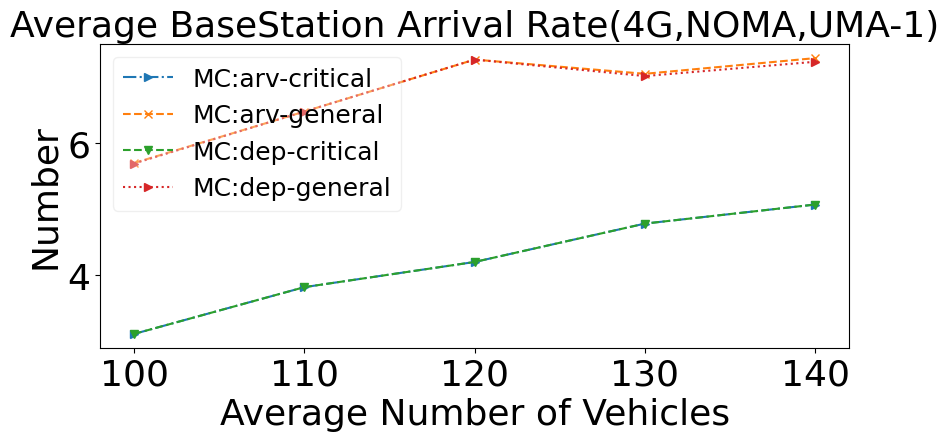

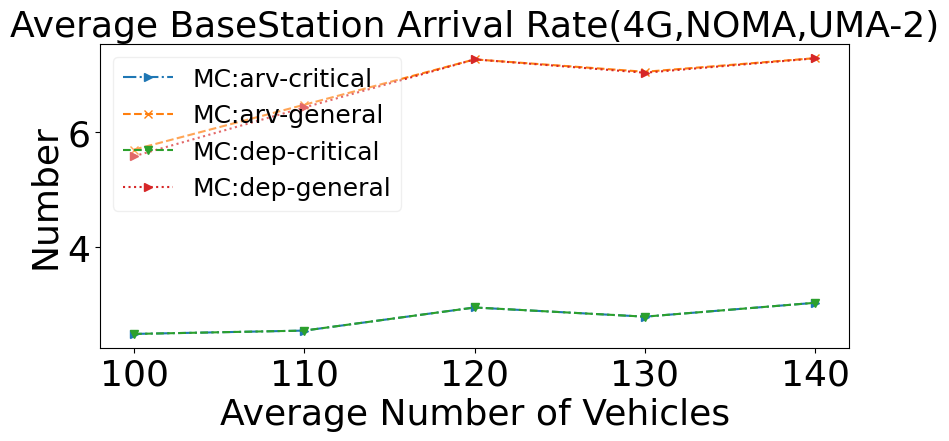

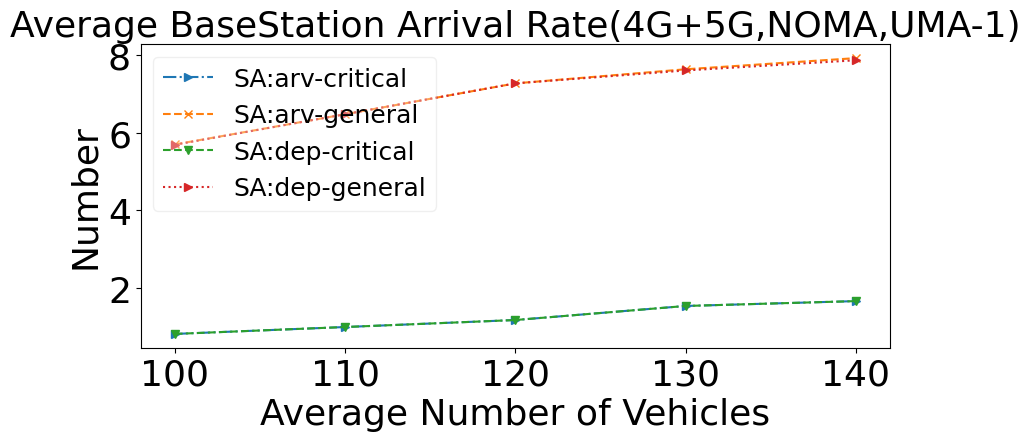

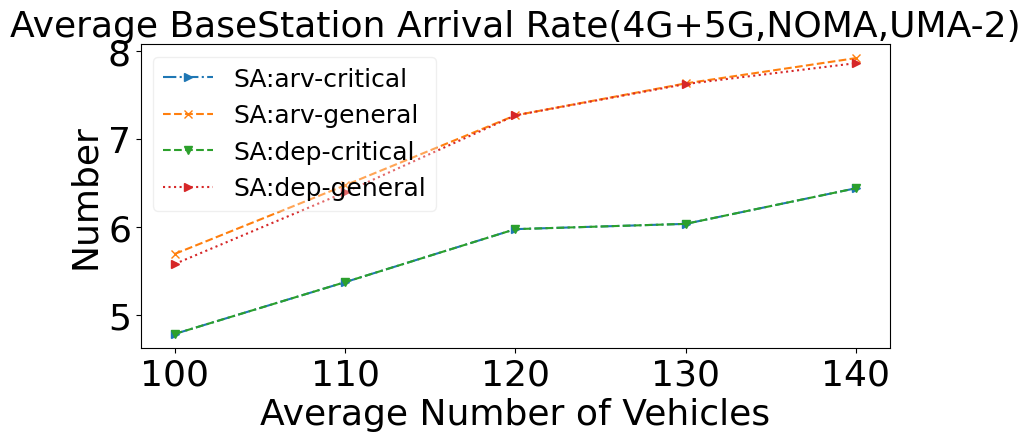

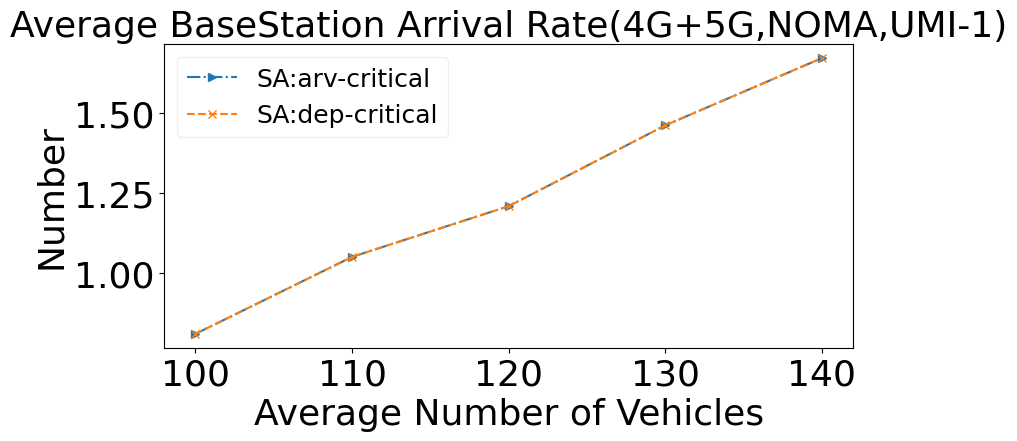

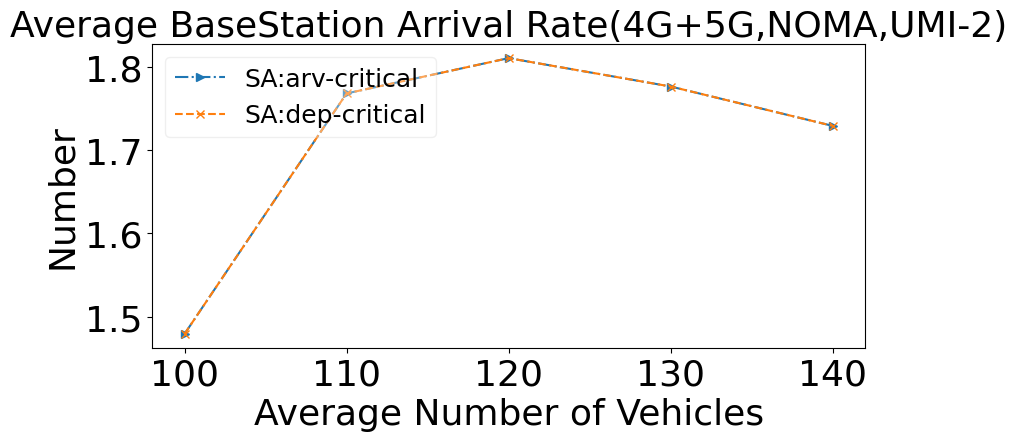

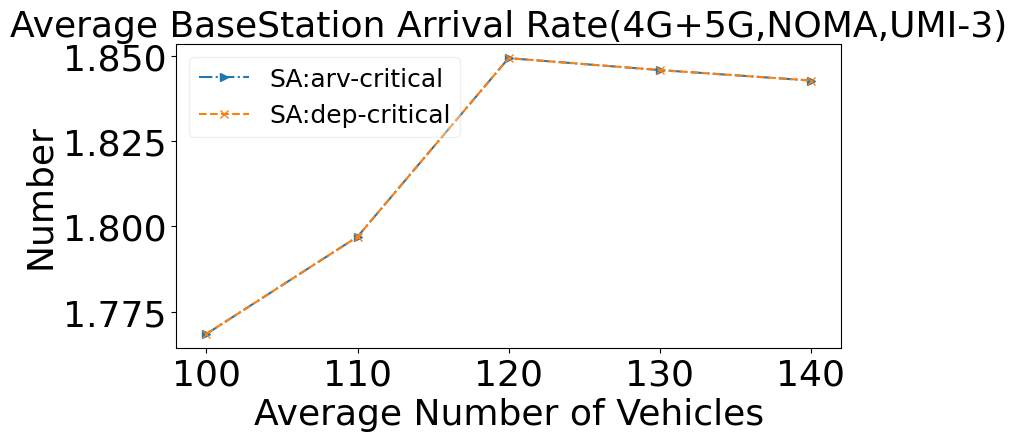

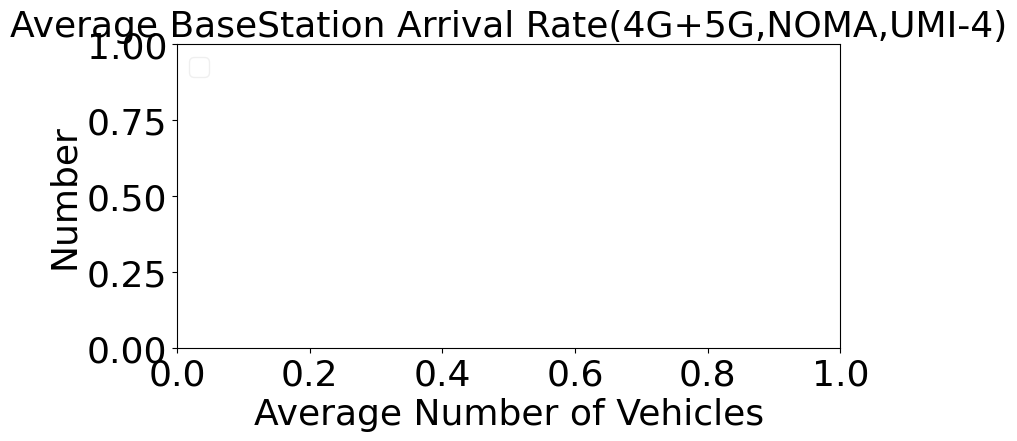

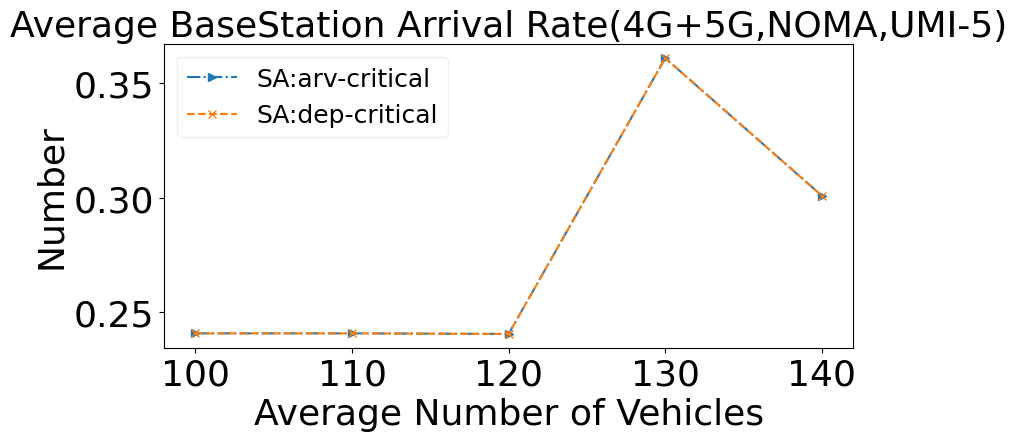

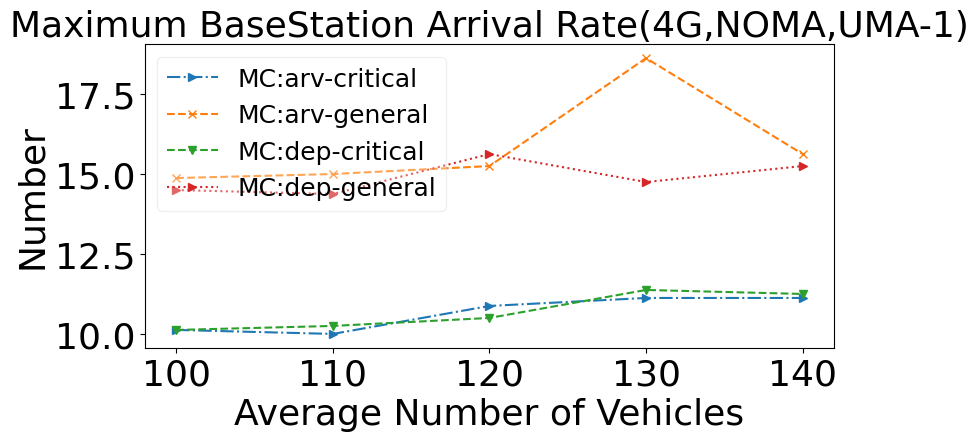

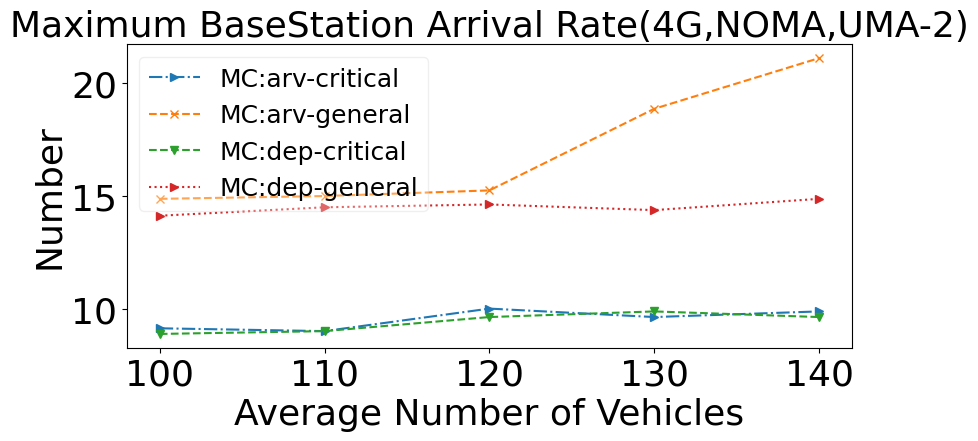

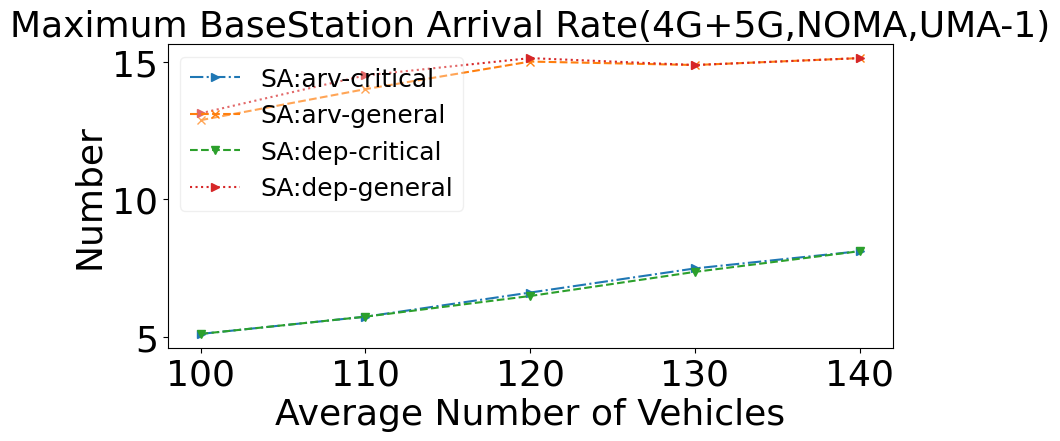

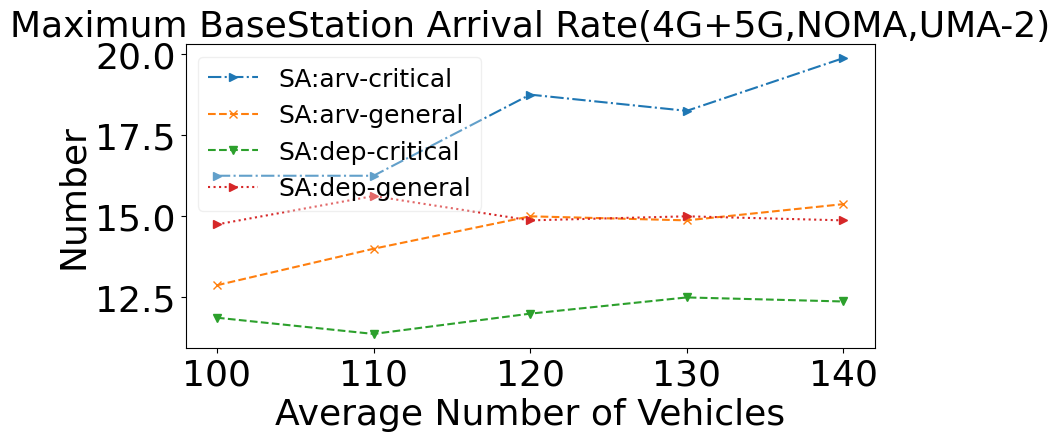

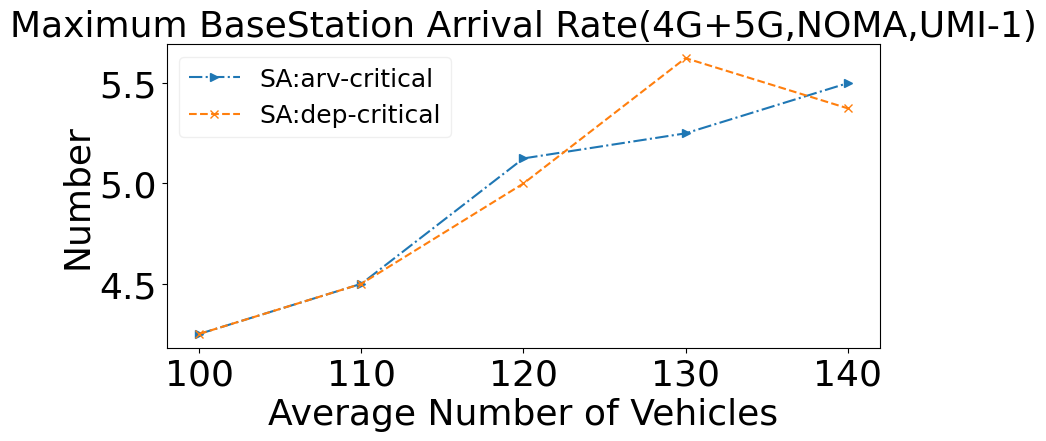

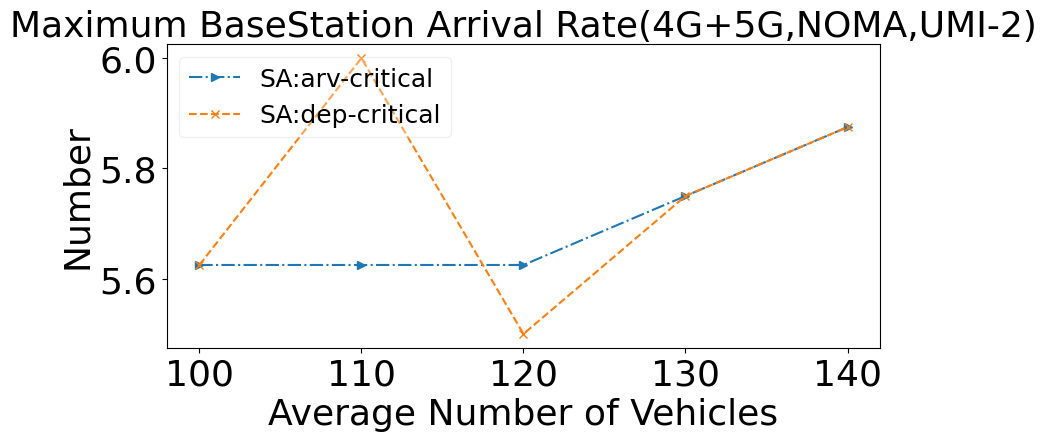

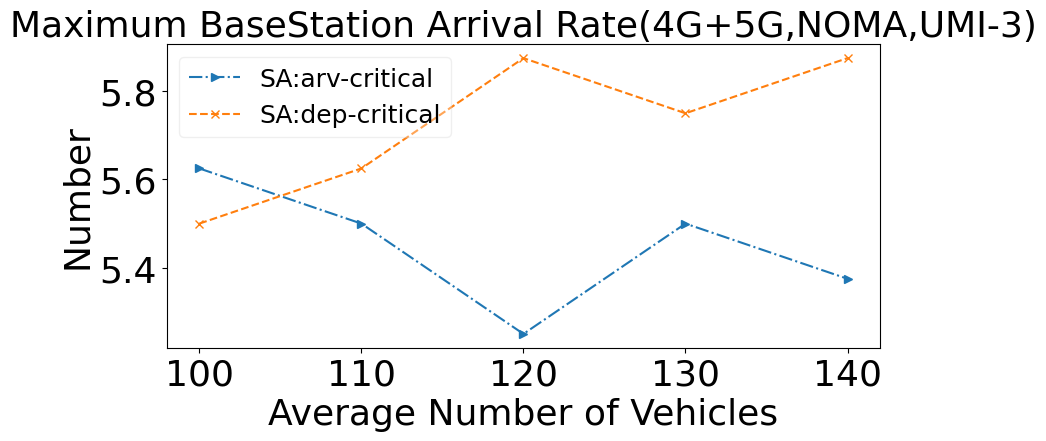

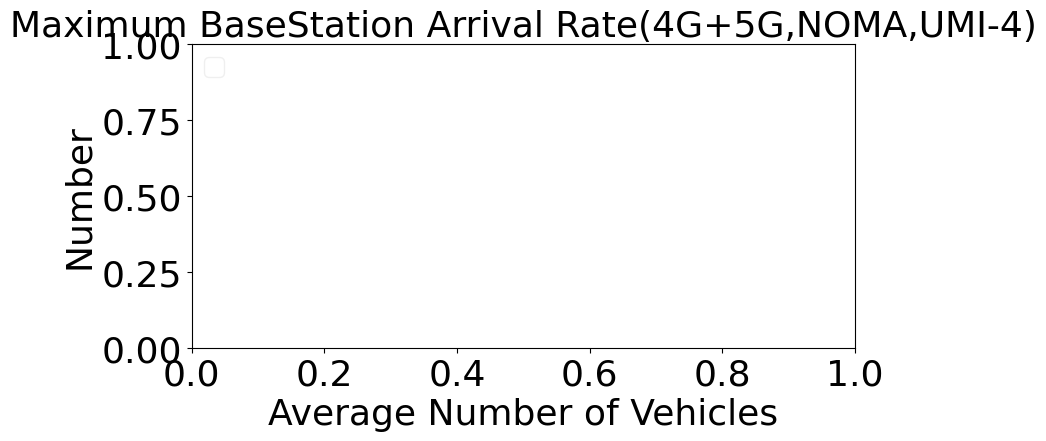

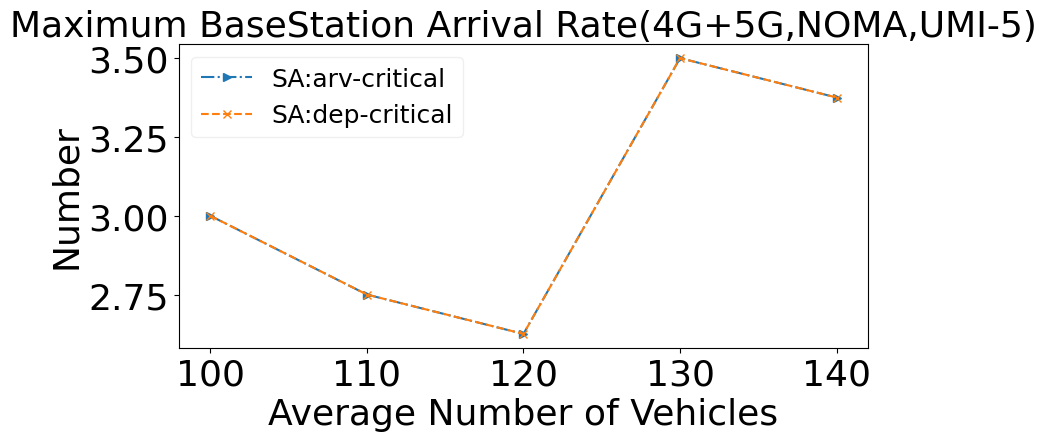

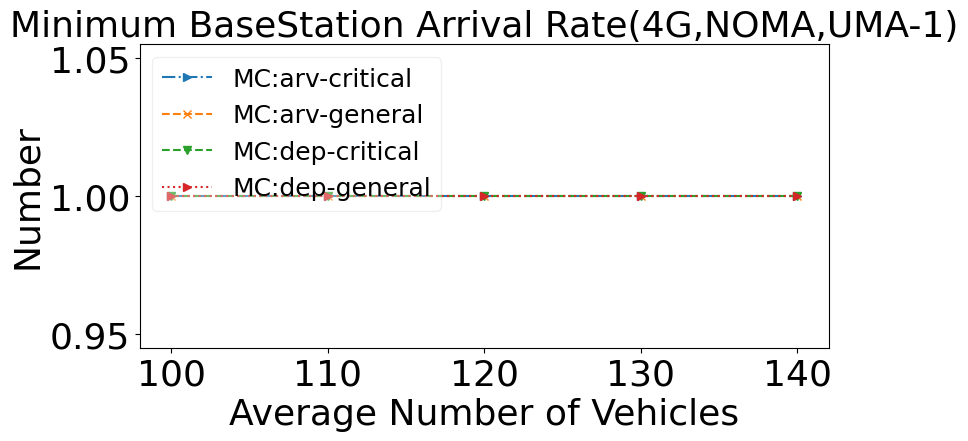

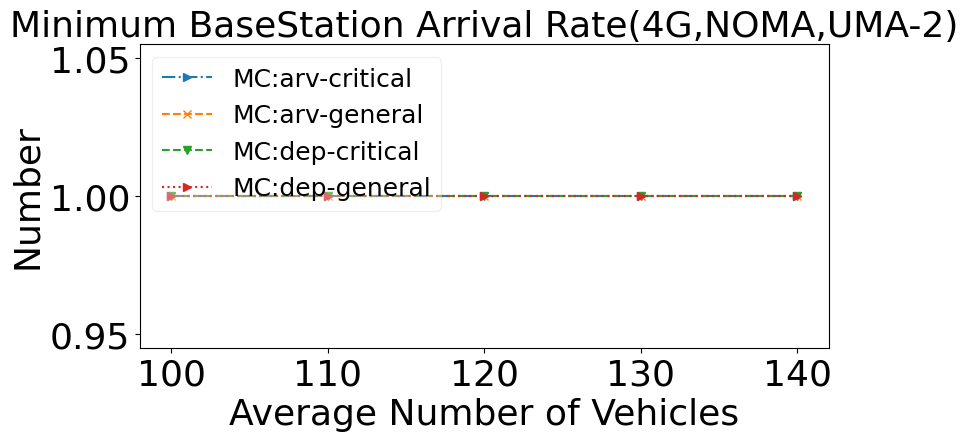

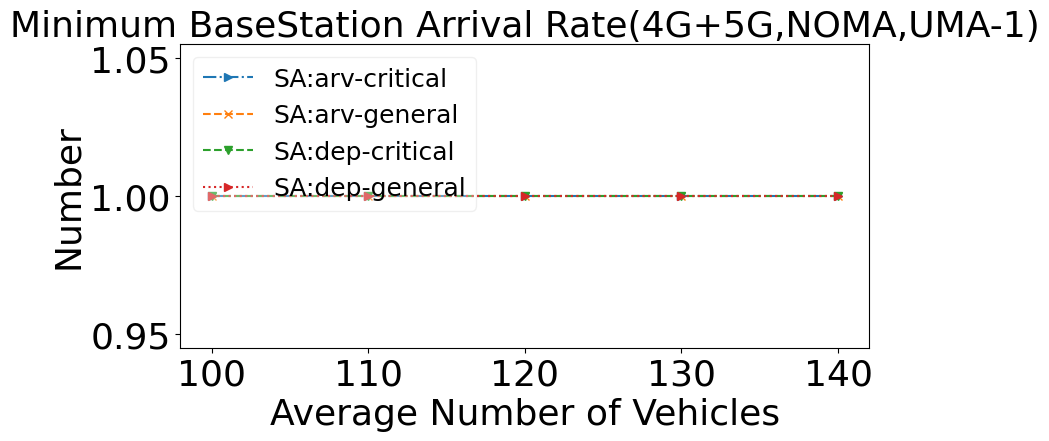

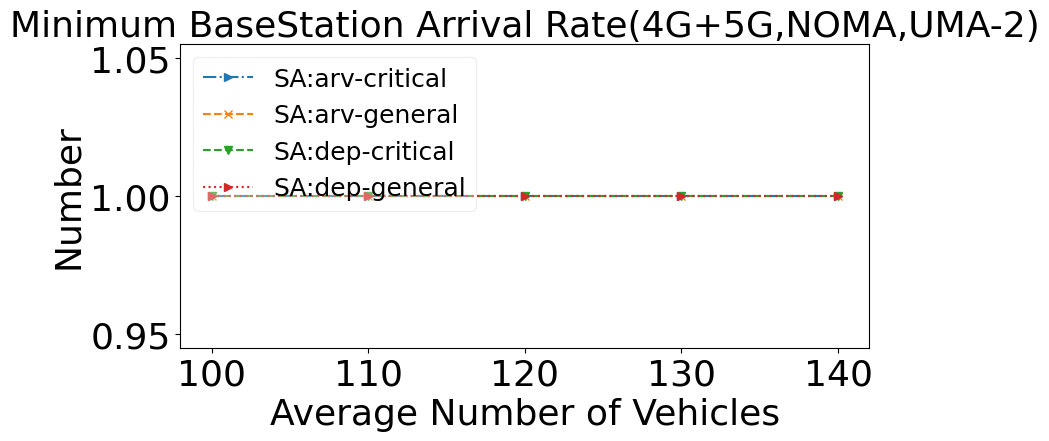

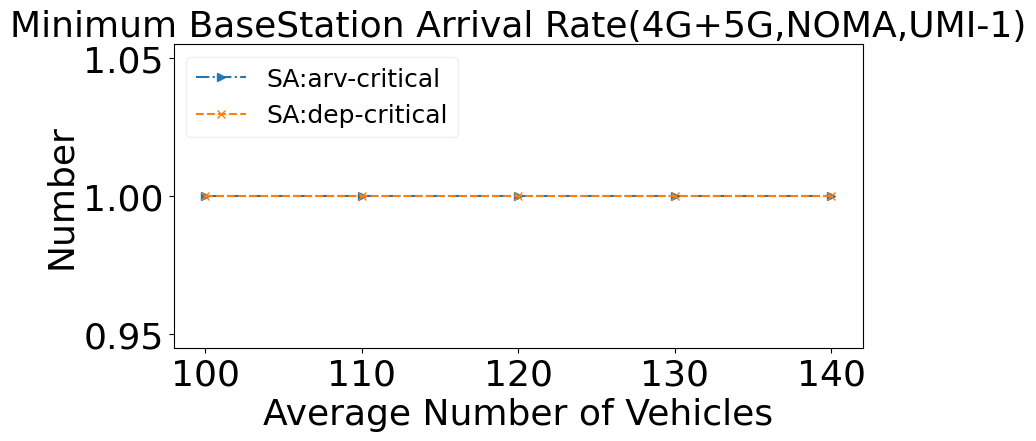

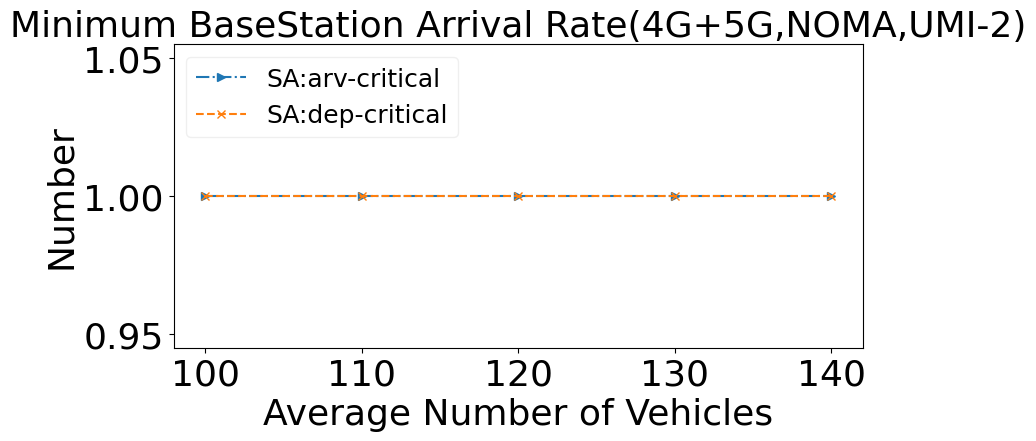

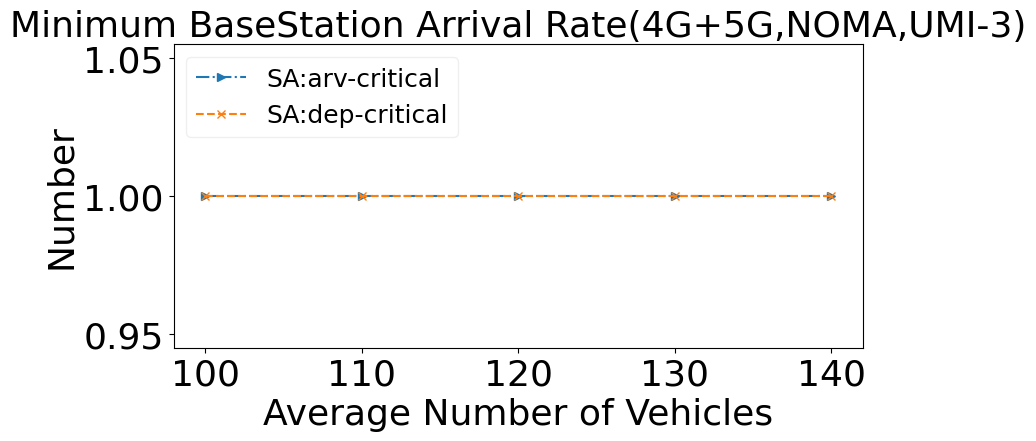

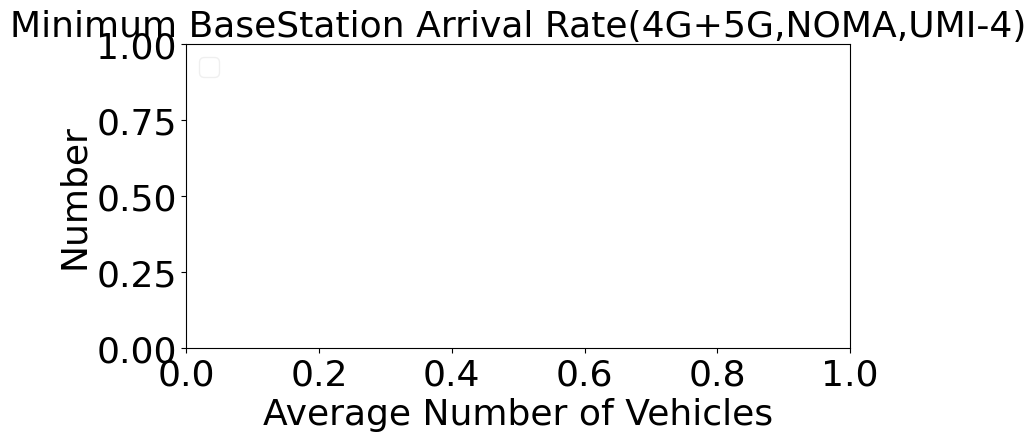

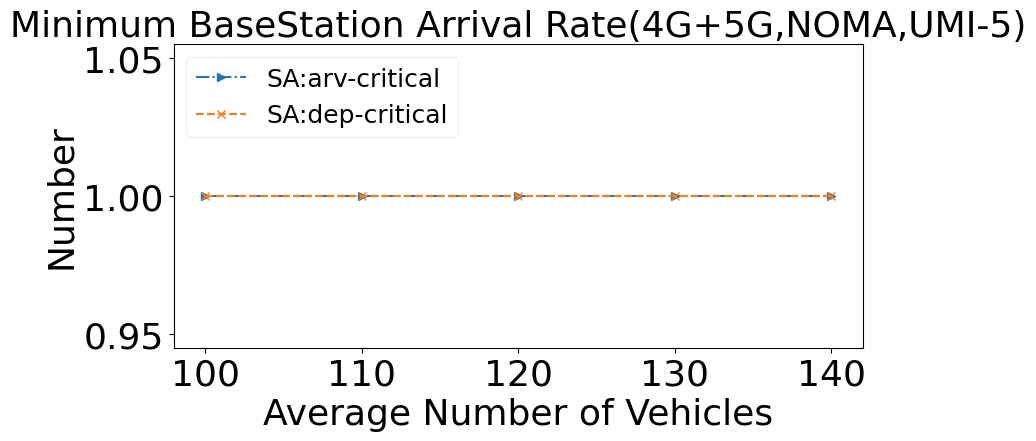

In [23]:
ShowGraphs(graphs,True)

In [133]:
print("Additional Lines")

Additional Lines


In [134]:
res_alloc_type_range = [ResourceAllocatorType.NOMA_OPT]
req_rsu_range = [True]
req_sa_qr = False

In [23]:
interest_config = InterestConfig(None, False, 0)
stats = {
        seed:{
        res_alloc_type :{
            req_rsu:{
                traffic_scale: None 
                for traffic_scale in traffic_scale_range
            }
            for req_rsu in req_rsu_range
        }
        for res_alloc_type in res_alloc_type_range
    }
    for seed in seed_range
}
for seed in seed_range:
    for res_alloc_type in res_alloc_type_range:
        for req_rsu in req_rsu_range:
            for traffic_scale in traffic_scale_range:
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    with open("data/nQoS/{}/{}/report.pickle".format(seed,str(interest_config)), "rb") as file:
                    # with open("data/nQoS/{}/{}/report_adjust_wait_time_nQoS.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                except:
                    print("missing: {} seed({})".format(str(interest_config),seed))

TypeError: __init__() missing 1 required positional argument: 'traffic_scale'

In [ ]:
configs = [
    {
        "catalog": "bst-thrput",
        "topic": "Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]
# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts)) + ["total"]
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v/(10**6))
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [ ]:
configs = [
    {
        "catalog": "bst-sg-rate",
        "topic": "QoS Service Traffic Ratio",
        "x": "Average Number of Vehicles",
        "y": "Percentage",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]


# intialize



for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in res_alloc_type_range:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                if(title not in graphs):
                    graphs[title] = Graph(title,config["x"],config["y"])
                graph = graphs[title]
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts))
                for nft in nfts:
                    y = []
                    x = [x * 100 for x in traffic_scale_range]
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*100)
                        y.append(sum(value)/len(value))
                    graph.addLine(
                        Line("{}:{}".format(ScenarioPrefix(req_rsu,req_sa_qr),nft.lower()),x,y)
                    )

In [ ]:
configs = [
    {
        "catalog": "sys-thrput",
        "topic": "System Throughput",
        "x": "Average Number of Vehicles",
        "y": "Megabits",
    },
]


# intialize


for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = topic
    if(title not in graphs):
        graphs[title] = Graph(title,config["x"],config["y"])
    graph = graphs[title]
    for req_rsu in req_rsu_range:
        for res_alloc_type in res_alloc_type_range:
            y = []
            x = [x * 100 for x in traffic_scale_range]
            for traffic_scale in traffic_scale_range:
                value = []
                for seed in seed_range:
                    v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog]["total"]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value.append(v/10**6)
                y.append(sum(value)/len(value))
            graph.addLine(
                        Line( 
                            "{}:{}/{}".format(
                                ScenarioPrefix(req_rsu,req_sa_qr),
                                AdjustResAllocTypeName(res_alloc_type),
                                BaseStationScenario(req_rsu)
                            ),
                             x,
                             y
                        )
            )

In [ ]:
ShowGraphs(graphs,True)